In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/train", transform=transform)
val_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/val", transform=transform)
test_data = datasets.ImageFolder("/home/enulu/Workspace/cv_term_project_FER/data/raf-db/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
num_classes = len(class_names)
print("✅ Classes:", class_names)


✅ Classes: ['1', '2', '3', '4', '5', '6', '7']


In [9]:
import torch
import torch.nn as nn
from torchvision import models

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# VGG16 + SE + Custom Classifier
class VGG16_SE_Custom(nn.Module):
    def __init__(self, num_classes=8):
        super(VGG16_SE_Custom, self).__init__()
        base = models.vgg16(pretrained=True)
        self.features = base.features  # convolutional backbone

        # Freeze backbone
        for param in self.features.parameters():
            param.requires_grad = True

        self.se = SEBlock(512)  # 512 is the output of VGG16 last conv layer

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.classifier(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16_SE_Custom(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/enulu/anaconda3/envs/fer/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/enulu/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [01:07<00:00, 8.19MB/s] 


In [11]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {trainable:,} / {total:,}")


Trainable params: 40,966,983 / 40,966,983


In [12]:


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    model.train()
    return correct / total


In [13]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Full Model Training

Epoch 1/10 | Avg Loss: 1.0228 | Train Acc: 0.6381 | Val Acc: 0.7445
Epoch 2/10 | Avg Loss: 0.6162 | Train Acc: 0.7853 | Val Acc: 0.7918
Epoch 3/10 | Avg Loss: 0.4285 | Train Acc: 0.8505 | Val Acc: 0.7837
Epoch 4/10 | Avg Loss: 0.2870 | Train Acc: 0.9050 | Val Acc: 0.7927
Epoch 5/10 | Avg Loss: 0.1865 | Train Acc: 0.9360 | Val Acc: 0.7910
Epoch 6/10 | Avg Loss: 0.1444 | Train Acc: 0.9515 | Val Acc: 0.7910
Epoch 7/10 | Avg Loss: 0.0933 | Train Acc: 0.9672 | Val Acc: 0.8041
Epoch 8/10 | Avg Loss: 0.0713 | Train Acc: 0.9752 | Val Acc: 0.7967
Epoch 9/10 | Avg Loss: 0.0787 | Train Acc: 0.9741 | Val Acc: 0.7878
Epoch 10/10 | Avg Loss: 0.0567 | Train Acc: 0.9821 | Val Acc: 0.7886


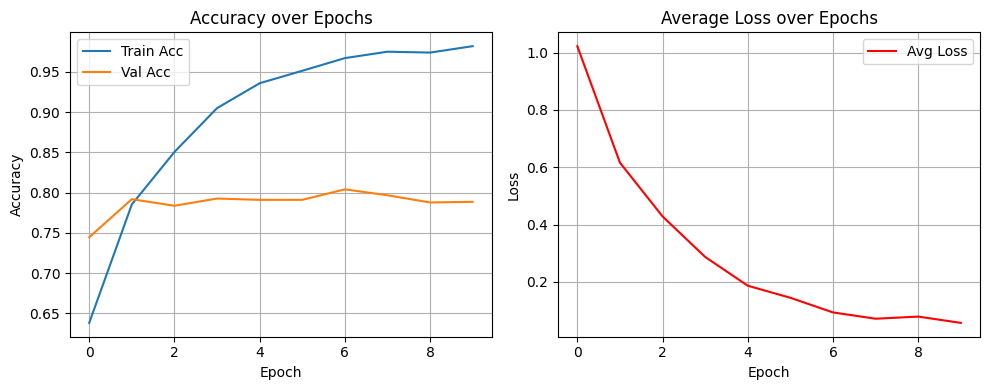

In [14]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.8110

🔍 Classification Report:

              precision    recall  f1-score   support

           1       0.80      0.81      0.81       329
           2       0.74      0.54      0.62        74
           3       0.44      0.51      0.47       160
           4       0.91      0.93      0.92      1185
           5       0.80      0.77      0.78       478
           6       0.75      0.64      0.69       162
           7       0.77      0.78      0.77       680

    accuracy                           0.81      3068
   macro avg       0.74      0.71      0.72      3068
weighted avg       0.81      0.81      0.81      3068



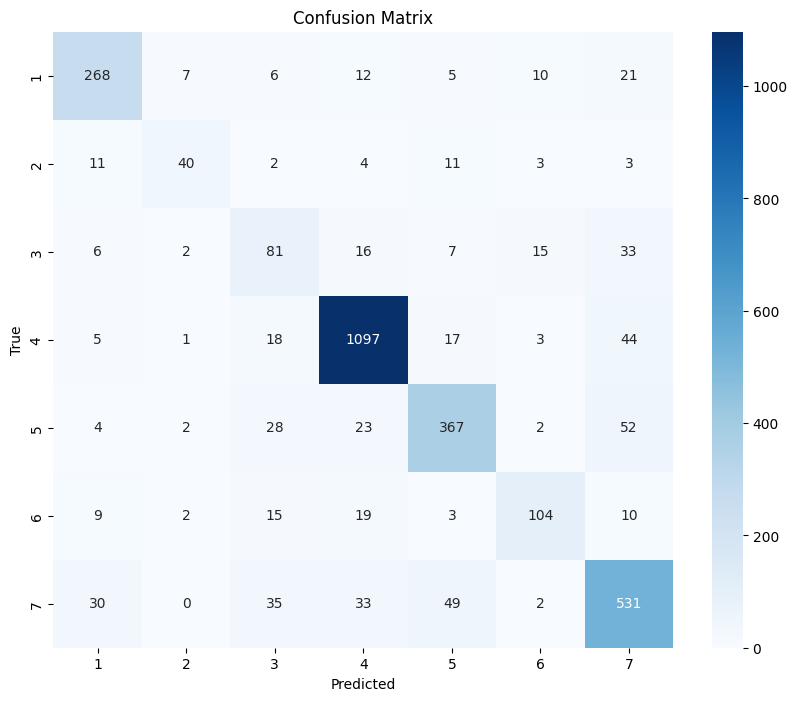

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# ✅ Classification Report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
